In [17]:
import re
import matplotlib.pyplot as plt


In [45]:
extracted_parameters = f"""
Material: steel
Tool Type: milling
Operation Type: milling
Desired Shape: custom shape
Workpiece Dimensions: 50mm x 50mm x 10mm
Starting Point: x=10, y=10
Home Position: x=0, y=0, z=0
Cutting Tool Coordinates: x=30, y=10 -> x=35, y=30 -> x=5, y=30 -> x=10, y=10
Return Tool to Home After Execution: yes
Coordinates: x, y
Depth of Cut: 2mm
Safety Instructions: ensure proper holding of workpiece during machining.
"""

params2 = f"""
Material: steel
Operation Type: milling
Desired Shape: custom shape
Workpiece Dimensions: 50mm x 50mm x 10mm
Starting Point: x=10, y=10
Home Position: x=0, y=0, z=0
Cutting Tool Path: (10,10,0) -> (30,10,0) -> (25,30,0) -> (15,30,0) -> (10,10,0)
Return Tool to Home After Execution: yes
Depth of Cut: 2mm
"""

In [43]:
def extract_numerical_values(parameters: dict, key: str):
    if key in parameters:
        # Regular expression to match numerical values
        numbers = re.findall(r'\d+', parameters[key])
        # Convert the extracted numbers to float
        numbers = list(map(float, numbers))
    else:
        numbers = 0 

    return numbers

def extract_path(parameters: dict, key: str):
    # Regular expression to find coordinates
    pattern = r'x=(-?\d+\.?\d*), y=(-?\d+\.?\d*)(?:, z=(-?\d+\.?\d*))?'

    # Find all matches
    matches = re.findall(pattern, parameters[key])

    # Convert matches to tuples of floats and set z to 0 if not given
    coordinates = [(float(x), float(y), float(z) if z else 0.0) for x, y, z in matches]

    return coordinates

In [46]:
def parse_parameters(parameter_string):
    parameters = {}
    parsed_parameters = {}
    for line in parameter_string.splitlines():
        if ": " in line:
            key, value = line.split(": ", 1)
            parameters[key.strip()] = value.strip()

    parsed_parameters['workpiece_diemensions'] = extract_numerical_values(parameters=parameters, key='Workpiece Dimensions') 
    parsed_parameters['starting_point'] = extract_numerical_values(parameters=parameters, key='Starting Point') 
    parsed_parameters['home_position'] = extract_numerical_values(parameters=parameters, key='Home Position') 
    parsed_parameters['tool_path'] = extract_path(parameters=parameters, key='Cutting Tool Path')
    parsed_parameters['cut_depth'] = extract_numerical_values(parameters=parameters, key='Depth of Cut') 

    return parsed_parameters

In [47]:
parsed_parameters = parse_parameters(params2)
print(parsed_parameters)

{'workpiece_diemensions': [50.0, 50.0, 10.0], 'starting_point': [10.0, 10.0], 'home_position': [0.0, 0.0, 0.0], 'tool_path': [], 'cut_depth': [2.0]}


In [33]:
def plot_cnc_task_2d(parsed_parameters):
    """Plots the CNC task in 2D."""

    wp_dims = parsed_parameters['workpiece_diemensions']
    start_point = parsed_parameters['starting_point']
    tool_path = parsed_parameters['tool_path']
    cut_depth = parsed_parameters['cut_depth'][0]

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot workpiece as a rectangle
    rect = plt.Rectangle((0, 0), wp_dims[0], wp_dims[1], 
                         linewidth=2, edgecolor='k', facecolor='lightgray')
    ax.add_patch(rect)

    # Plot tool path
    x_path, y_path, _ = zip(*tool_path)  # Ignore z-coordinates for 2D plot

    # Move to starting point if not already at the beginning
    if tool_path and (start_point[0], start_point[1]) != tool_path[0]:
        x_path = (start_point[0],) + x_path
        y_path = (start_point[1],) + y_path

    ax.plot(x_path, y_path, 'r-', linewidth=2, label='Tool Path')

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title('CNC Task Visualization (2D)')
    ax.legend()

    # Set axis limits to match workpiece dimensions
    ax.set_xlim([0, wp_dims[0]])
    ax.set_ylim([0, wp_dims[1]])

    # Add cut depth as text annotation
    ax.text(0.05, 0.95, f'Cut Depth: {cut_depth}mm', 
            transform=ax.transAxes, verticalalignment='top')

    plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
    plt.show()

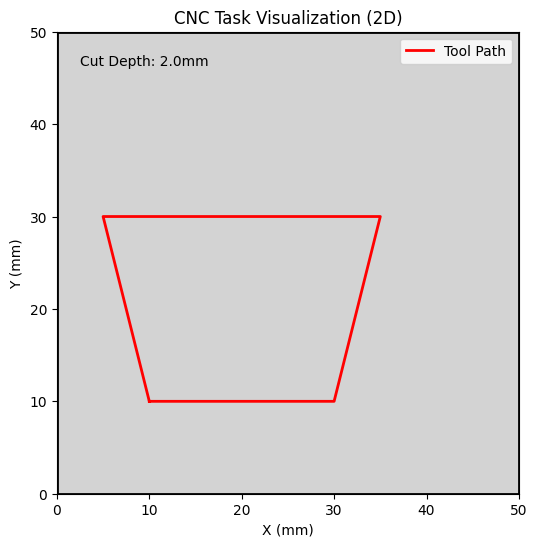

In [34]:
plot_cnc_task_2d(parsed_parameters)


In [3]:
import itertools

list_1 = [(10,10), (10,10), (10,30), (35,30), (5,30), (10, 10)]

list_2 = [(10,10), (10,30), (10,30), (35,30), (5,30), (10, 10), (10, 10)]

list_1 = [k for k, _ in itertools.groupby(list_1)]
list_2 = [k for k, _ in itertools.groupby(list_2)]
print(list_1)
print(list_2)

[(10, 10), (10, 30), (35, 30), (5, 30), (10, 10)]
[(10, 10), (10, 30), (35, 30), (5, 30), (10, 10)]


In [ ]:
Here's a completion of the `validate_functional_correctness` function that compares the two tool paths while considering potential repeated tuples and different list lengths:

```python
def validate_functional_correctness(gcode_string):
    x_points, y_points = parse_gcode(gcode_string)
    gcode_tool_path = [(x,y) for x, y in zip(x_points, y_points)]

    if st.session_state['parsed_parameters'] is not None:
        user_defined_start_point = st.session_state['parsed_parameters']['starting_point']
        tool_path = st.session_state['parsed_parameters']['tool_path']

        # Plot tool path
        x_path, y_path, _ = zip(*tool_path)  # Ignore z-coordinates for 2D plot

        # Move to starting point if not already at the beginning
        if tool_path and (user_defined_start_point[0], user_defined_start_point[1]) != tool_path[0]:
            x_path = (user_defined_start_point[0],) + x_path
            y_path = (user_defined_start_point[1],) + y_path

        user_defined_tool_path = [(x,y) for x, y in zip(x_path, y_path)]

        # Remove consecutive duplicates from both paths
        gcode_tool_path = [k for k, _ in itertools.groupby(gcode_tool_path)]
        user_defined_tool_path = [k for k, _ in itertools.groupby(user_defined_tool_path)]

        # Calculate the Hausdorff distance between the two paths
        def hausdorff_distance(path1, path2):
            def point_distance(p1, p2):
                return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

            def directed_hausdorff(path_a, path_b):
                return max(min(point_distance(a, b) for b in path_b) for a in path_a)

            return max(directed_hausdorff(path1, path2), directed_hausdorff(path2, path1))

        distance = hausdorff_distance(gcode_tool_path, user_defined_tool_path)

        # Define a tolerance for the Hausdorff distance
        tolerance = 0.1  # Adjust this value based on your requirements

        if distance <= tolerance:
            return True, f"Tool paths match within tolerance. Hausdorff distance: {distance:.4f}"
        else:
            return False, f"Tool paths do not match. Hausdorff distance: {distance:.4f}"

    return False, "Unable to compare tool paths. Missing user-defined parameters."
```

This completion adds the following functionality:

1. It removes consecutive duplicates from both tool paths using `itertools.groupby()`. This addresses the issue of repeated tuples in the lists.

2. It implements the Hausdorff distance calculation to compare the two paths. The Hausdorff distance measures how far two subsets of a metric space are from each other. It's particularly useful for comparing paths that may have different lengths or slight deviations.

3. It defines a tolerance value for the Hausdorff distance. You can adjust this value based on how strict you want the comparison to be.

4. The function returns a boolean indicating whether the paths match within the tolerance, along with a message providing more details.

This approach allows for a meaningful comparison of the two tool paths even when they have different lengths or slight variations. The Hausdorff distance provides a measure of similarity that's more robust than a simple point-by-point comparison.

Would you like me to explain any part of this code in more detail?